## Импорт библиотек и функций

In [ ]:
!pip install optuna-integration -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.4/93.4 kB 1.4 MB/s eta 0:00:00


In [ ]:
!pip install shap -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 5.4 MB/s eta 0:00:00


In [ ]:
!pip install imbalanced-learn -q

In [ ]:
!pip install phik -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 7.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import warnings
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from optuna.integration import OptunaSearchCV
from optuna import distributions
from sklearn.model_selection import cross_val_score, cross_val_predict
import shap
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC, LinearSVR
from imblearn.over_sampling import SMOTE
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from sklearn.ensemble import RandomForestClassifier

In [ ]:
warnings.filterwarnings('ignore')

## Описание проекта

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён.

Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли.

Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

## Цель работы

У вас будет несколько задач. Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.

Ваша вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

## Описание данных

Для этой задачи заказчик предоставил данные с признаками:

- `id` — уникальный идентификатор сотрудника;
- `dept` — отдел, в котором работает сотрудник;
- `level` — уровень занимаемой должности;
- `workload` — уровень загруженности сотрудника;
- `employment_years` — длительность работы в компании (в годах);
- `last_year_promo` — показывает, было ли повышение за последний год;
- `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
- `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
- `salary` — ежемесячная зарплата сотрудника;
- `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак.
- `quit` — увольнение сотрудника из компании

## Задача 1: предсказание уровня удовлетворённости сотрудника

### Загрузка данных

In [ ]:
try:
  train_job_satisfaction_rate = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
  test_features = pd.read_csv('/datasets/test_features.csv')
  test_target_job_satisfaction_rate = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')
except:
  train_job_satisfaction_rate = pd.read_csv('/content/train_job_satisfaction_rate.csv')
  test_features = pd.read_csv('/content/test_features.csv')
  test_target_job_satisfaction_rate = pd.read_csv('/content/test_target_job_satisfaction_rate.csv')

In [ ]:
train_job_satisfaction_rate.info()
train_job_satisfaction_rate.sample(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
2566,256645,hr,junior,medium,3,no,no,4,30000,0.8
2846,380088,marketing,middle,low,2,no,no,5,20400,0.5


- в train_job_satisfaction_rate присутствуют немногочисленные пропуски в данных в стобцах dept, level
- данные в train_job_satisfaction_rate соответствуют описанию данных

In [ ]:
test_features.info()
test_features.sample(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
742,745992,sales,junior,low,3,no,no,3,18000
558,685726,technology,middle,high,6,no,no,5,62400


- в test_features присутствуют немногочисленные пропуски в данных в стобцах dept, level
- данные в test_features соответствуют описанию данных

In [ ]:
test_target_job_satisfaction_rate.info()
test_target_job_satisfaction_rate.sample(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


,id,job_satisfaction_rate
1112,308241,0.4
327,512740,0.2


- данные в test_target_job_satisfaction_rate соответствуют описанию данных

**Вывод по разделу**
- в train_job_satisfaction и test_features присутствуют немногочисленные пропуски в данных в стобцах dept, level
- все данные трех датасетов соответствуют описанию данных

###  Предобработка данных

In [ ]:
print('Кол-о дубликатов:',train_job_satisfaction_rate['id'].duplicated().sum())
print('Кол-о дубликатов:',test_features['id'].duplicated().sum())
print('Кол-о дубликатов:',test_target_job_satisfaction_rate['id'].duplicated().sum())

Кол-о дубликатов: 0
Кол-о дубликатов: 0
Кол-о дубликатов: 0


- явных дубликатов в полученных данных не обнаружено

In [ ]:
print('Кол-о дубликатов:',train_job_satisfaction_rate.drop('id', axis=1).duplicated().sum())
df_test = test_features.merge(test_target_job_satisfaction_rate)
print('Кол-о дубликатов:',df_test.drop('id', axis=1).duplicated().sum())

Кол-о дубликатов: 245
Кол-о дубликатов: 83


- найдены неявные дубликаты в признаках сотрудников (абсолютно идентичные по признакам сотрудники), будем считать такие записи багрепортом, решено удалить их из рассмотрения

In [ ]:
df = train_job_satisfaction_rate.set_index('id')
df_test = df_test.set_index('id')

In [ ]:
df = df.drop_duplicates()
print(df.shape)
print(df_test.shape)

(3755, 9)
(2000, 9)


**Выводы по разделу**
- явных дубликатов в полученных данных не обнаружено
- найдены неявные дубликаты в признаках сотрудников (абсолютно идентичные по признакам сотрудники), будем считать такие записи багрепортом, удалены из рассмотрения

### Исследовательский анализ данных

- перед началом исследовательского анализа разделим признаки на три категории: численные, категориальные и ранжированные

In [ ]:
ohe_columns = ['dept','last_year_promo','last_year_violations']
ord_columns = ['level', 'workload', 'employment_years', 'supervisor_evaluation']
num_columns = ['salary', 'job_satisfaction_rate']

**Анализ тренировочной выборки:**

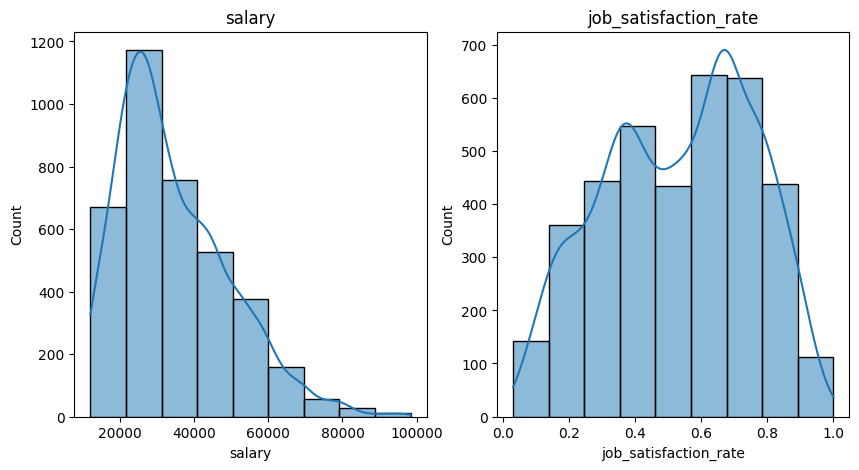

In [ ]:
plt.rcParams['figure.figsize'] = [10, 5]
j = 0
for i in num_columns:
    j += 1
    plt.subplot(1,2,j)
    sns.histplot(df[i], kde=True,bins=
                 round(np.log(df['salary'].count()))+1).set_title(i)

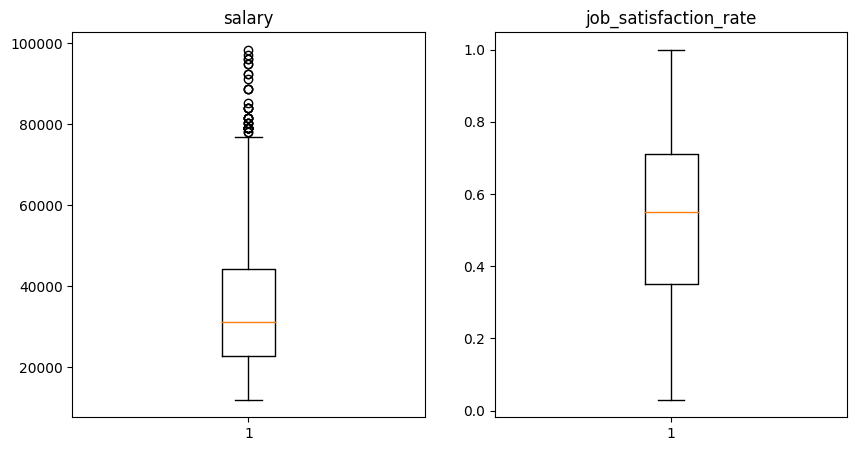

In [ ]:
j = 0
for i in num_columns:
    j += 1
    plt.subplot(1,2,j)
    plt.boxplot(df[i])
    plt.title(i)

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
employment_years,3755.0,3.817044,2.557142,1.00,2.00,3.00,6.00,10.0
supervisor_evaluation,3755.0,3.463648,1.026265,1.00,3.00,4.00,4.00,5.0
salary,3755.0,34457.416778,15050.643870,12000.00,22800.00,31200.00,44400.00,98400.0
job_satisfaction_rate,3755.0,0.532554,0.226393,0.03,0.35,0.55,0.71,1.0


- визуальный анализ показал, что у большинства признаков наблюдается распределение Пуассона, рекомендуется при корреляционном анализе использовать метод Спирмена
- видно ряд выбросов в столбце salary, это можно объяснить тем, что высокие заработные платы в компании из-за иерархической структуры у малого процентного числа работников

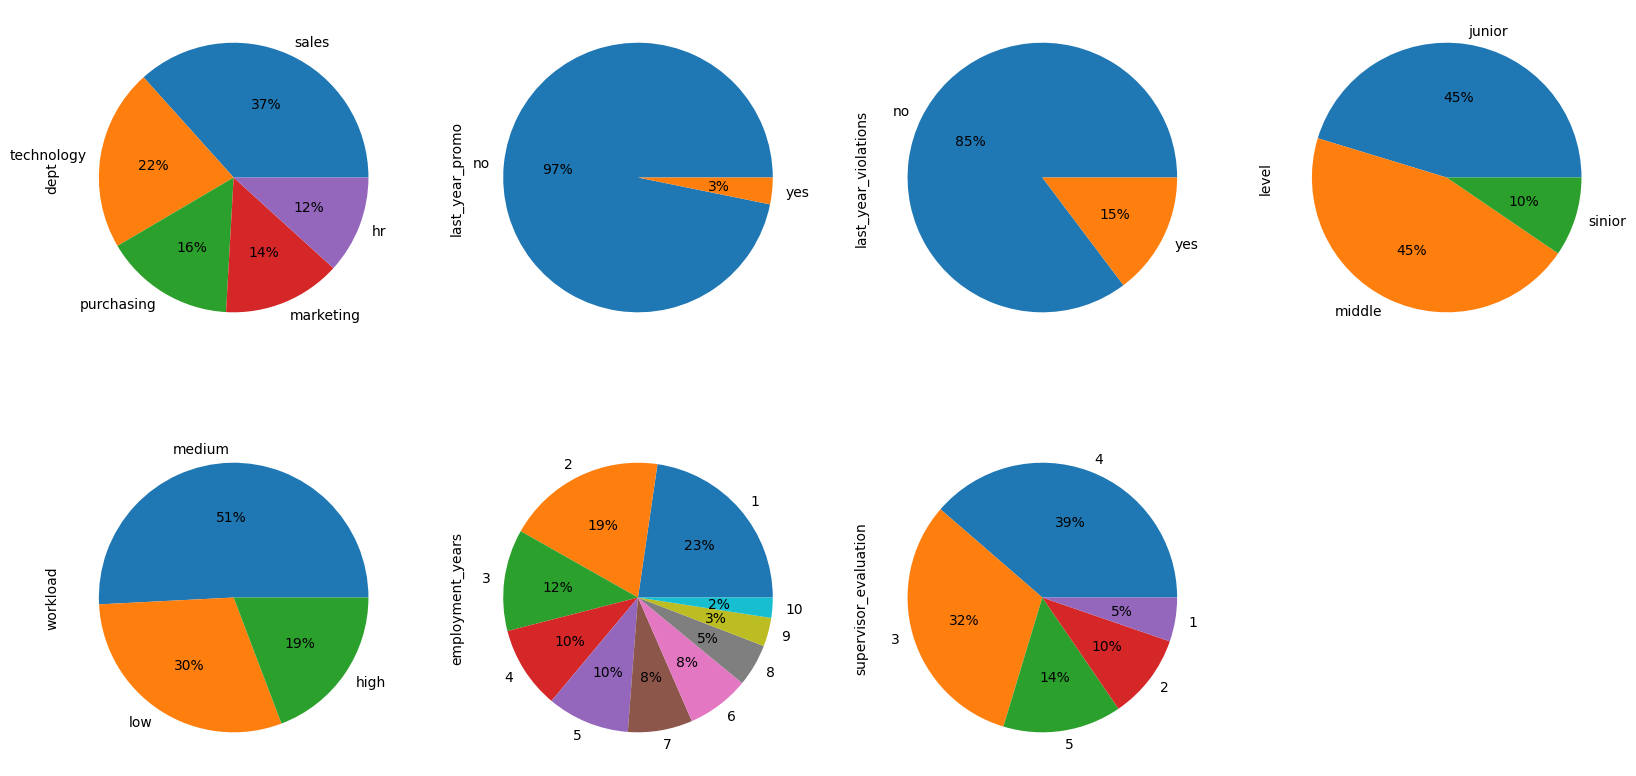

In [ ]:
plt.rcParams['figure.figsize'] = [20, 10]
j = 0
for i in ohe_columns + ord_columns:
    j += 1
    plt.subplot(2,4,j)
    df[i].value_counts().plot(kind='pie',autopct='%1.0f%%');

- наблюдается ярковыраженный дисбаланс класса в столбцах last_year_promo, last_year_violations

**Анализ тестовой выборки:**

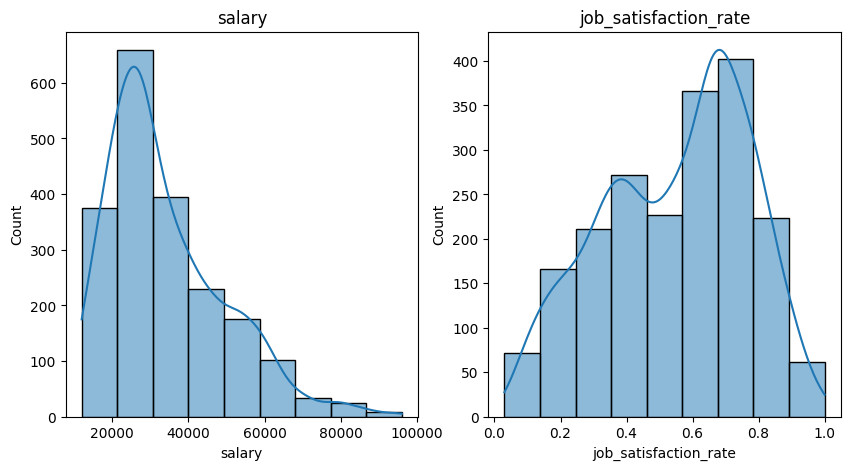

In [ ]:
plt.rcParams['figure.figsize'] = [10, 5]
j = 0
for i in num_columns:
    j += 1
    plt.subplot(1,2,j)
    sns.histplot(df_test[i], kde=True,bins=
                 round(np.log(df_test['salary'].count()))+1).set_title(i)

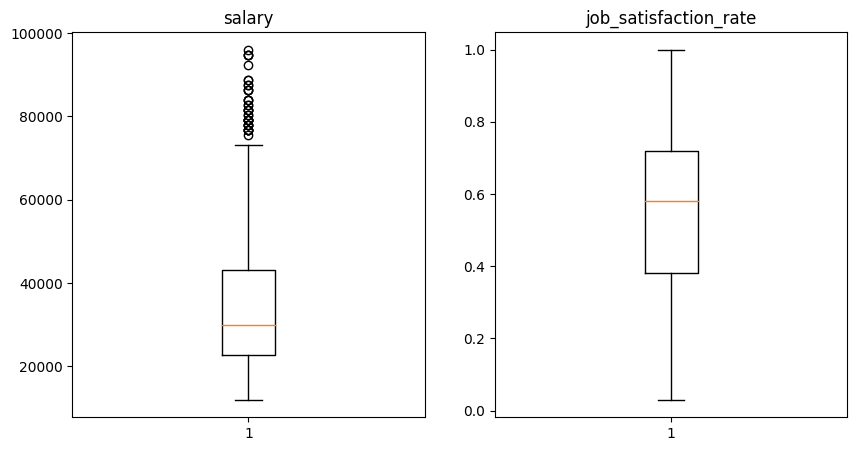

In [ ]:
j = 0
for i in num_columns:
    j += 1
    plt.subplot(1,2,j)
    plt.boxplot(df_test[i])
    plt.title(i)

In [ ]:
df_test.describe().T

,count,mean,std,min,25%,50%,75%,max
employment_years,2000.0,3.66650,2.537222,1.00,1.00,3.00,6.00,10.0
supervisor_evaluation,2000.0,3.52650,0.996892,1.00,3.00,4.00,4.00,5.0
salary,2000.0,34066.80000,15398.436729,12000.00,22800.00,30000.00,43200.00,96000.0
job_satisfaction_rate,2000.0,0.54878,0.220110,0.03,0.38,0.58,0.72,1.0


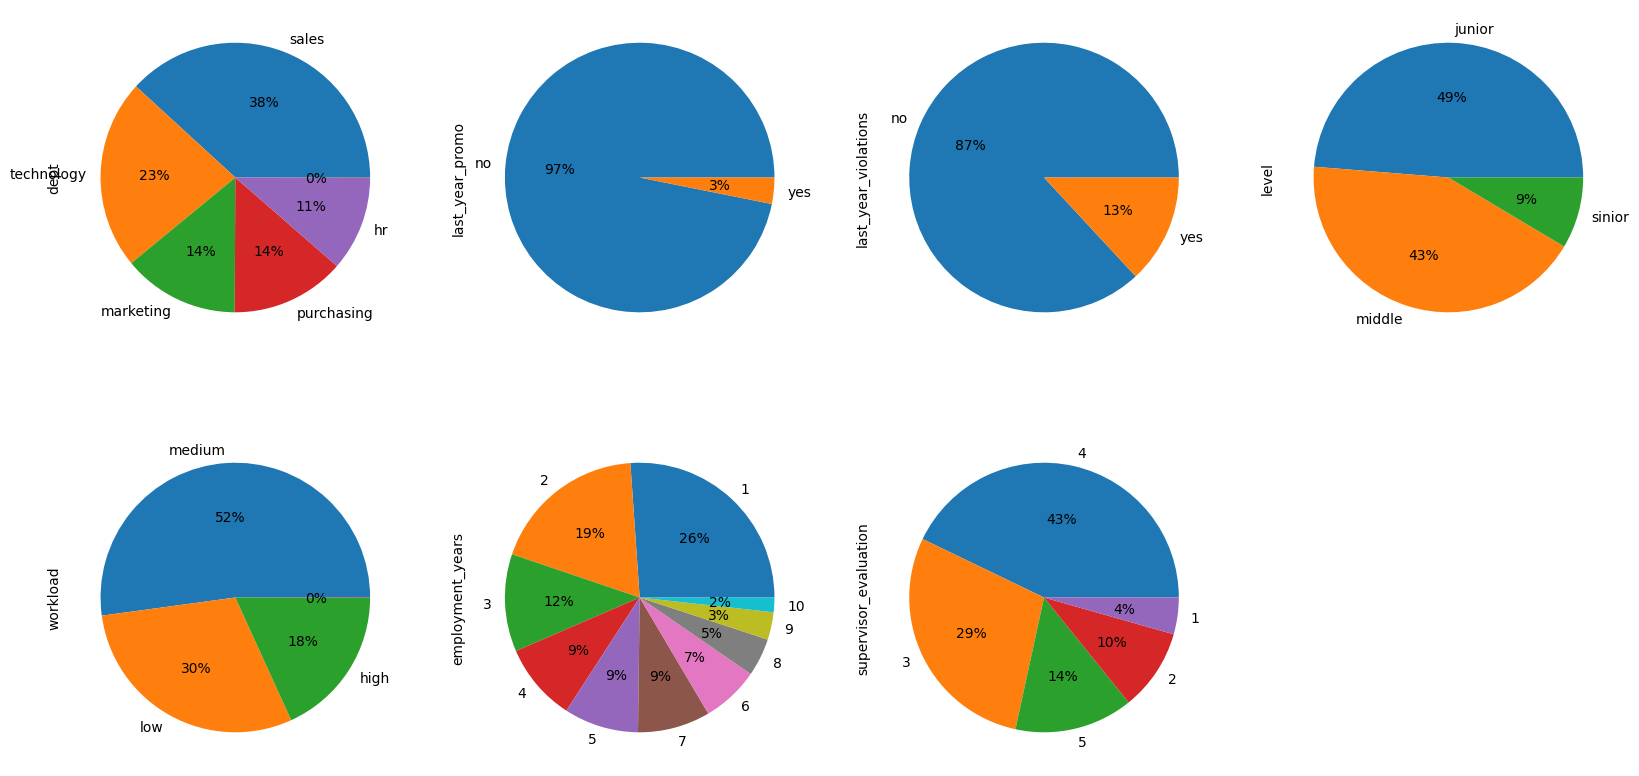

In [ ]:
plt.rcParams['figure.figsize'] = [20, 10]
j = 0
for i in ohe_columns+ord_columns:
    j += 1
    plt.subplot(2,4,j)
    df_test[i].value_counts().plot(kind='pie',autopct='%1.0f%%');

- признаки тестовой выборки имеют схожий характер с тренировочными

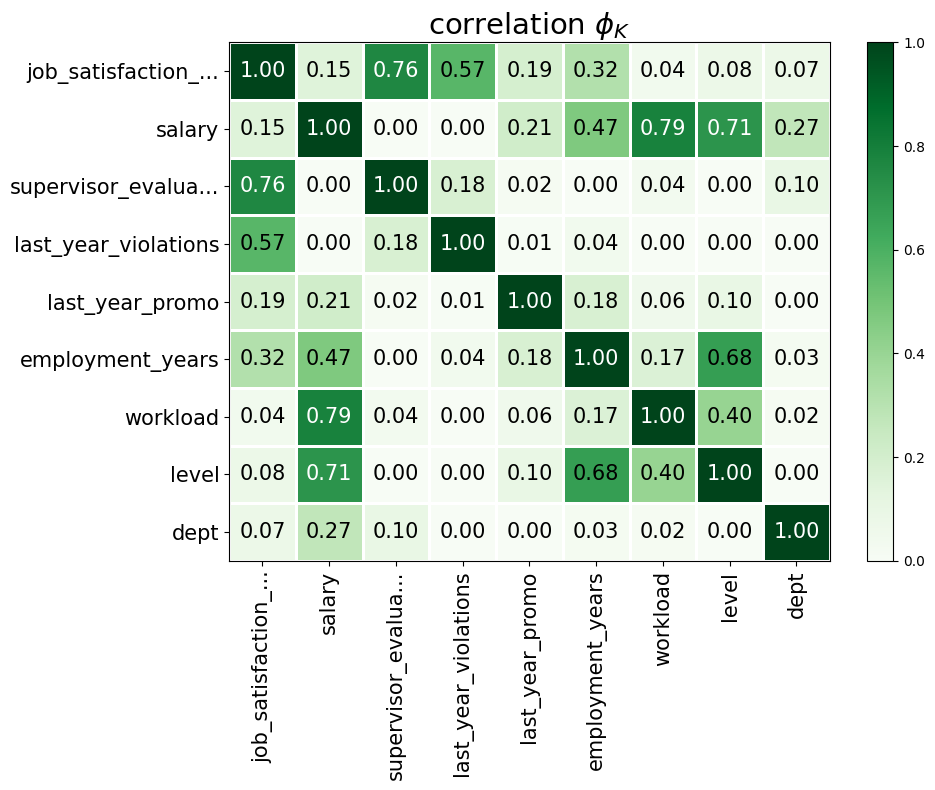

In [ ]:
phik_overview = phik_matrix(df, interval_cols=num_columns)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(10, 8)
)

- корреляционный анализ показал, что целевой признак имеет высокую зависимость от supervisir_evalution и заметную зависимость от last_year_violations

**Вывод по разделу**
- визуальный анализ показал, что у большинства признаков наблюдается распределение Пуассона, рекомендуется при корреляционном анализе использовать метод Спирмена
- видно ряд выбросов в столбце salary, это можно объяснить тем, что высокие заработные платы в компании из-за иерархической структуры у малого процентного числа работников
- наблюдается ярковыраженный дисбаланс класса в столбцах last_year_promo, last_year_violations
- признаки тестовой выборки имеют схожий характер с тренировочными
- корреляционный анализ показал, что целевой признак имеет высокую зависимость от supervisir_evalution и заметную зависимость от last_year_violations

### Подготовка данных

In [ ]:
RANDOM_STATE = 42

X_train=df.drop(['job_satisfaction_rate'], axis=1)
y_train=df['job_satisfaction_rate']
X_test=df_test.drop(['job_satisfaction_rate'], axis=1)
y_test=df_test['job_satisfaction_rate']

ohe_columns = ['dept','last_year_promo','last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['salary', 'employment_years', 'supervisor_evaluation']

In [ ]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
    ]
    )

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high'],
                   ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ],
    remainder='passthrough'
)

**Вывод по разделу**
- подготовка признаков выполнена в пайплайне
- для признаков проведено масштабирование и кодирование
- при кодировании использовался OneHotEncoder для критериальных признаков и OrdinalEncoder для ранжированных признаков

### Обучение моделей

**Создание метрики SMAPE**

SMAPE (англ. symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение»).
Метрика SMAPE вычисляется так:

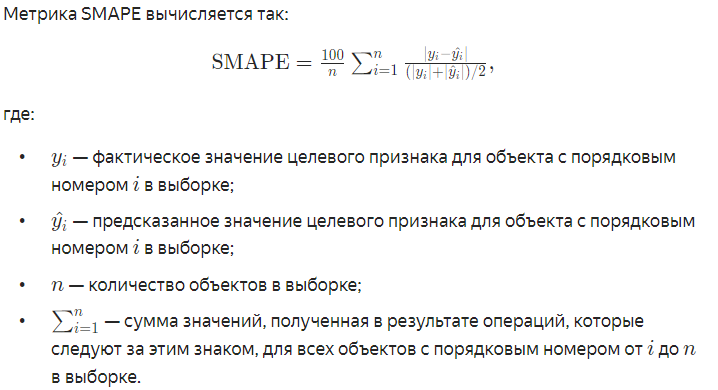

Критерий успеха: SMAPE ≤15 на тестовой выборке

Создание своей метрики:

In [ ]:
def smape(y_true, y_pred):
    metric=200/len(y_pred)*sum(abs(y_true-y_pred)/(abs(y_pred)+abs(y_true)))
    return metric
scorer = make_scorer(smape, greater_is_better= False)

- Для разработки модели предсказание уровня удовлетворённости сотрудника использовались модели DecisionTreeClassifier, LinearRegression и LinearSVR, для автоматизации подбора гиперпараметров используем RandomizedSearchCV

In [ ]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': [None] + [i for i in range(2, 7)],
        'models__max_features': range(1, 100),
        'models__max_leaf_nodes': range(1, 50),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },


    # словарь для модели LeniarRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },

    {
        'models': [LinearSVR(random_state=RANDOM_STATE)],
        'models__С': [1, 0.5 , 0.1, 2, 5, 10]  ,
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }

]

randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring=scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', -(randomized_search.best_score_))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                   

При первой итерации получены следующая модель с ее гиперпараметрами:
- DecisionTreeRegressor(max_features=32, max_leaf_nodes=48,random_state=42)

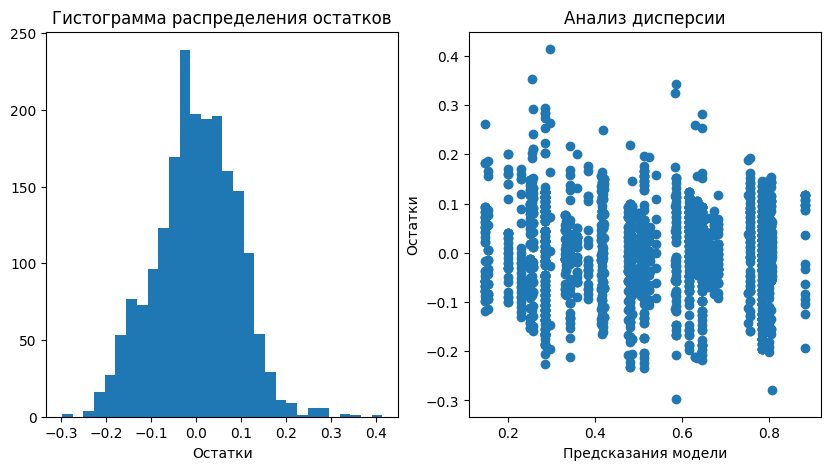

In [ ]:
y_pred=randomized_search.predict(X_test)
residuals = y_test - y_pred
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals, bins=30)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')
axes[1].scatter(x=y_pred, y=residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

Анализ гистограммы распредления остатков и анализ дисперсии показал:
- Гистаграмма распределения остатков не смещена относительно 0, значит модель в среднем не завышает и не занижает результаты
- График анализа дисперсии показывает, что остатки модели независимы на всём диапазоне использования модели, её разброс постоянный

- Для более детального подбора гиперпараметров воспольземся OptunaSearchCV

In [ ]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

parameters = {
        'models__max_depth': distributions.CategoricalDistribution([None] + [i for i in range(2, 7)]),
        'models__max_features': distributions.IntDistribution(1, 500),
        'models__max_leaf_nodes': distributions.IntDistribution(1, 500),
        'preprocessor__num': distributions.CategoricalDistribution([StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'])
}


oscv = OptunaSearchCV(
    pipe_final,
    parameters,
    scoring=scorer,
    n_jobs=-1,
    cv=5,
    n_trials=50,
    random_state=RANDOM_STATE
)

oscv.fit(X_train, y_train)


print('Лучшая модель и её параметры:\n\n', oscv.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', -(oscv.best_score_))



# рассчет прогноз на тестовых данных
y_test_pred = oscv.predict(X_test)

print(f'Метрика SMAPE на тестовой выборке: {smape(y_test, y_test_pred)}')

[I 2024-03-24 12:13:11,087] A new study created in memory with name: no-name-8ec335c6-13b3-4c1a-a2c5-f30029d66667
[I 2024-03-24 12:13:11,532] Trial 1 finished with value: -22.69173894305095 and parameters: {'models__max_depth': 3, 'models__max_features': 278, 'models__max_leaf_nodes': 423, 'preprocessor__num': MinMaxScaler()}. Best is trial 1 with value: -22.69173894305095.
[I 2024-03-24 12:13:11,579] Trial 0 finished with value: -19.231560257019016 and parameters: {'models__max_depth': 6, 'models__max_features': 382, 'models__max_leaf_nodes': 130, 'preprocessor__num': StandardScaler()}. Best is trial 0 with value: -19.231560257019016.
[I 2024-03-24 12:13:11,966] Trial 2 finished with value: -15.718391422452587 and parameters: {'models__max_depth': None, 'models__max_features': 186, 'models__max_leaf_nodes': 162, 'preprocessor__num': 'passthrough'}. Best is trial 2 with value: -15.718391422452587.
[I 2024-03-24 12:13:12,030] Trial 3 finished with value: -22.69173894305095 and parameter

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                   

Гиперпараметры модели с наилучшей метрикой выглядят так :  
- DecisionTreeRegressor(max_features=219, max_leaf_nodes=439,random_state=42)
- StandardScaler()
- OneHotEncoder(drop='first',handle_unknown='ignore', sparse=False)
- OrdinalEncoder( categories=[['junior', 'middle', 'sinior'],['low', 'medium', 'high'],[1,2,3,4,5,6,7,8,9,10],[1,2,3,4,5]],handle_unknown='use_encoded_value', unknown_value=np.nan)
- SimpleImputer(strategy='most_frequent')

- метрика SMAPE на тестовой выборке оказалась <15, следовательно точность прогнозирования модели можно считать достаточной

**Вывод по разделу**

- создана своя метрика SMAPE, критерий успехадя которой SMAPE ≤15 на тестовой выборке
- для разработки модели предсказание уровня удовлетворённости сотрудника использовались модели DecisionTreeClassifier, LinearRegression и LinearSVR, для автоматизации подбора гиперпараметров используем RandomizedSearchCV

При первой итерации получены следующая модель с ее гиперпараметрами:

- DecisionTreeRegressor(max_features=32, max_leaf_nodes=48,random_state=42)

Анализ гистограммы распредления остатков и анализ дисперсии показал:

- гистаграмма распределения остатков не смещена относительно 0, значит модель в среднем не завышает и не занижает результаты
- график анализа дисперсии показывает, что остатки модели независимы на всём диапазоне использования модели, её разброс постоянный
- для более детального подбора гиперпараметров использовался OptunaSearchCV

Гиперпараметры модели с наилучшей метрикой выглядят так :

- DecisionTreeRegressor(max_features=231, max_leaf_nodes=360,random_state=42)DecisionTreeRegressor(max_features=238, max_leaf_nodes=367,random_state=42)
- StandardScaler()
- OneHotEncoder(drop='first',handle_unknown='ignore', sparse=False)
- OrdinalEncoder( categories=[['junior', 'middle', 'sinior'],['low', 'medium', 'high'],[1,2,3,4,5,6,7,8,9,10],[1,2,3,4,5]],handle_unknown='use_encoded_value', unknown_value=np.nan)
- SimpleImputer(strategy='most_frequent')

- метрика SMAPE на тестовой выборке оказалась <15, следовательно точность прогнозирования модели можно считать достаточной

### Вывод по задаче 1

В данной задаче разработана модель, которая предсказывает уровень удовлетворённости сотрудника

Данные были получены из следующих файлов /datasets/train_job_satisfaction_rate.csv, /datasets/test_features.csv, /datasets/test_target_job_satisfaction_rate.csv. Перед началом исследовательской части был произведен обзор и проверка на адекватность полученных данных. Выявлено, что:

- в train_job_satisfaction и test_features присутствуют немногочисленные пропуски в данных в стобцах dept, level
- все данные трех датасетов соответствуют описанию данных

Перед началом исследования была проведена предобработка данных,в рамках которой выялено:

- явных дубликатов в полученных данных не обнаружено
- найдены неявные дубликаты в признаках сотрудников (абсолютно идентичные по признакам сотрудники), будем считать такие записи багрепортом, удалены из рассмотрения

В ходе исследования данных выявлены следующие особенности:

- визуальный анализ показал, что у большинства признаков наблюдается распределение Пуассона, рекомендуется при корреляционном анализе использовать метод Спирмена
- видно ряд выбросов в столбце salary, это можно объяснить тем, что высокие заработные платы в компании из-за иерархической структуры у малого процентного числа работников
- наблюдается ярковыраженный дисбаланс класса в столбцах last_year_promo, last_year_violations
- признаки тестовой выборки имеют схожий характер с тренировочными
- корреляционный анализ показал, что целевой признак имеет высокую зависимость от supervisir_evalution и заметную зависимость от last_year_violations

Перед началом обучения проведена подоготвка дынных:

- подготовка признаков выполнена в пайплайне
- для признаков проведено масштабирование и кодирование
- при кодировании использовался OneHotEncoder для критериальных признаков и OrdinalEncoder для ранжированных признаков

На этапе обучения модели были выполнены следующие процедуры:

- создана своя метрика SMAPE, критерий успехадя которой SMAPE ≤15 на тестовой выборке
- для разработки модели предсказание уровня удовлетворённости сотрудника использовались модели DecisionTreeClassifier, LinearRegression и LinearSVR, для автоматизации подбора гиперпараметров используем RandomizedSearchCV

При первой итерации получены следующая модель с ее гиперпараметрами:

- DecisionTreeRegressor(max_features=32, max_leaf_nodes=48,random_state=42)

Анализ гистограммы распредления остатков и анализ дисперсии показал:

- гистаграмма распределения остатков не смещена относительно 0, значит модель в среднем не завышает и не занижает результаты
- график анализа дисперсии показывает, что остатки модели независимы на всём диапазоне использования модели, её разброс постоянный
- для более детального подбора гиперпараметров использовался OptunaSearchCV

Гиперпараметры модели с наилучшей метрикой выглядят так :

- DecisionTreeRegressor(max_features=219, max_leaf_nodes=439,random_state=42)
- StandardScaler()
- OneHotEncoder(drop='first',handle_unknown='ignore', sparse=False)
- OrdinalEncoder( categories=[['junior', 'middle', 'sinior'],['low', 'medium', 'high'],[1,2,3,4,5,6,7,8,9,10],[1,2,3,4,5]],handle_unknown='use_encoded_value', unknown_value=np.nan)
- SimpleImputer(strategy='most_frequent')

- метрика SMAPE на тестовой выборке оказалась <15, следовательно точность прогнозирования модели можно считать достаточной

## Задача 2: предсказание увольнения сотрудника из компании

### Загрузка данных

In [ ]:
try:
  train_quit = pd.read_csv('/datasets/train_quit.csv')
  test_target_quit = pd.read_csv('/datasets/test_target_quit.csv')
except:
  train_quit = pd.read_csv('/content/train_quit.csv')
  test_target_quit = pd.read_csv('/content/test_target_quit.csv')

In [ ]:
train_quit.info()
train_quit.sample(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
2840,508063,marketing,middle,medium,4,no,no,3,36000,no
830,698054,sales,middle,high,3,no,no,5,60000,no


- данные в train_quit соответствуют описанию данных

In [ ]:
test_features.info()
test_features.sample(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1758,223063,sales,middle,medium,6,no,no,4,38400
1105,189726,purchasing,junior,low,2,no,yes,3,19200


- данные в test_features соответствуют описанию данных

In [ ]:
test_target_quit.info()
test_target_quit.sample(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


,id,quit
1696,293404,no
510,770414,yes


- данные в test_target_quit соответствуют описанию данных

**Вывод по разделу**
- все данные трех датасетов соответствуют описанию данных

###  Предобработка данных

In [ ]:
print('Кол-во дубликатов:',train_quit['id'].duplicated().sum())
print('Кол-во дубликатов:',test_features['id'].duplicated().sum())
print('Кол-во дубликатов:',test_target_quit['id'].duplicated().sum())

Кол-во дубликатов: 0
Кол-во дубликатов: 0
Кол-во дубликатов: 0


- явных дубликатов в данных не обнаружено

In [ ]:
df = train_quit.copy()
df_test = test_features.merge(test_target_quit)
print(df.shape)
print(df_test.shape)

(4000, 10)
(2000, 10)


In [ ]:
df = df.set_index('id')
df_test = df_test.set_index('id')
print('Кол-во дубликатов:',df.duplicated().sum())
print('Кол-во дубликатов:',df_test.duplicated().sum())

Кол-во дубликатов: 1413
Кол-во дубликатов: 504


- найдены неявные дубликаты в признаках сотрудников (абсолютно идентичные по признакам сотрудники), будем считать такие записи багрепортом, решено удалить их из рассмотрения

In [ ]:
df = df.drop_duplicates()
print(df.shape)
print(df_test.shape)

(2587, 9)
(2000, 9)


**Выводы по разделу**
- явных дубликатов в данных не обнаружено
- найдены неявные дубликаты в признаках сотрудников (абсолютно идентичные по признакам сотрудники), будем считать такие записи багрепортом, решено удалить их из рассмотрения

### Исследовательский анализ данных

In [ ]:
ohe_columns = ['dept','last_year_promo','last_year_violations','quit']
ord_columns = ['level', 'workload', 'employment_years', 'supervisor_evaluation']
num_columns = ['salary']

**Анализ тренировочной выборки:**

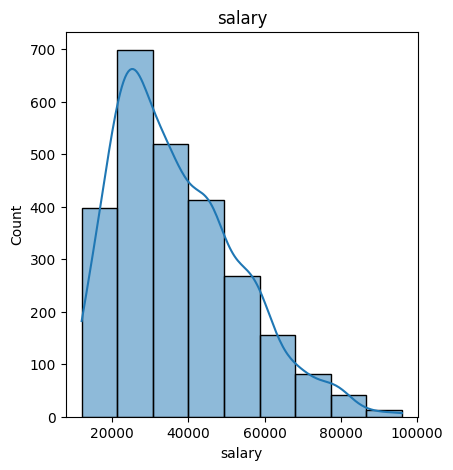

In [ ]:
plt.rcParams['figure.figsize'] = [10, 5]
j = 0
for i in num_columns:
    j += 1
    plt.subplot(1,2,j)
    sns.histplot(df[i], kde=True,bins=
                 round(np.log(df['salary'].count()))+1).set_title(i)

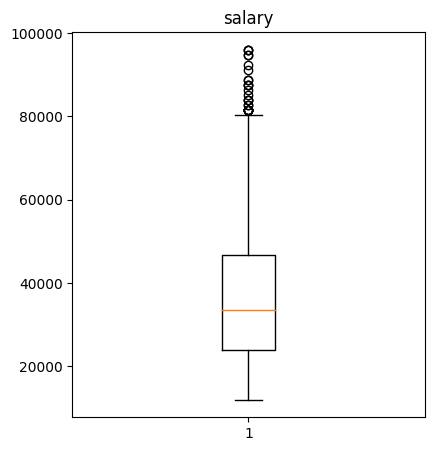

In [ ]:
j = 0
for i in num_columns:
    j += 1
    plt.subplot(1,2,j)
    plt.boxplot(df[i])
    plt.title(i)

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
employment_years,2587.0,4.213375,2.601105,1.0,2.0,4.0,6.0,10.0
supervisor_evaluation,2587.0,3.367994,1.080243,1.0,3.0,3.0,4.0,5.0
salary,2587.0,37107.692308,16267.354906,12000.0,24000.0,33600.0,46800.0,96000.0


- визуальный анализ показал, что у большинства признаков наблюдается распределение Пуассона, рекомендуется при корреляционном анализе использовать метод Спирмена
- видно ряд выбросов в столбце salary, это можно объяснить тем, что высокие заработные платы в компании из-за иерархической структуры у малого процентного числа работников

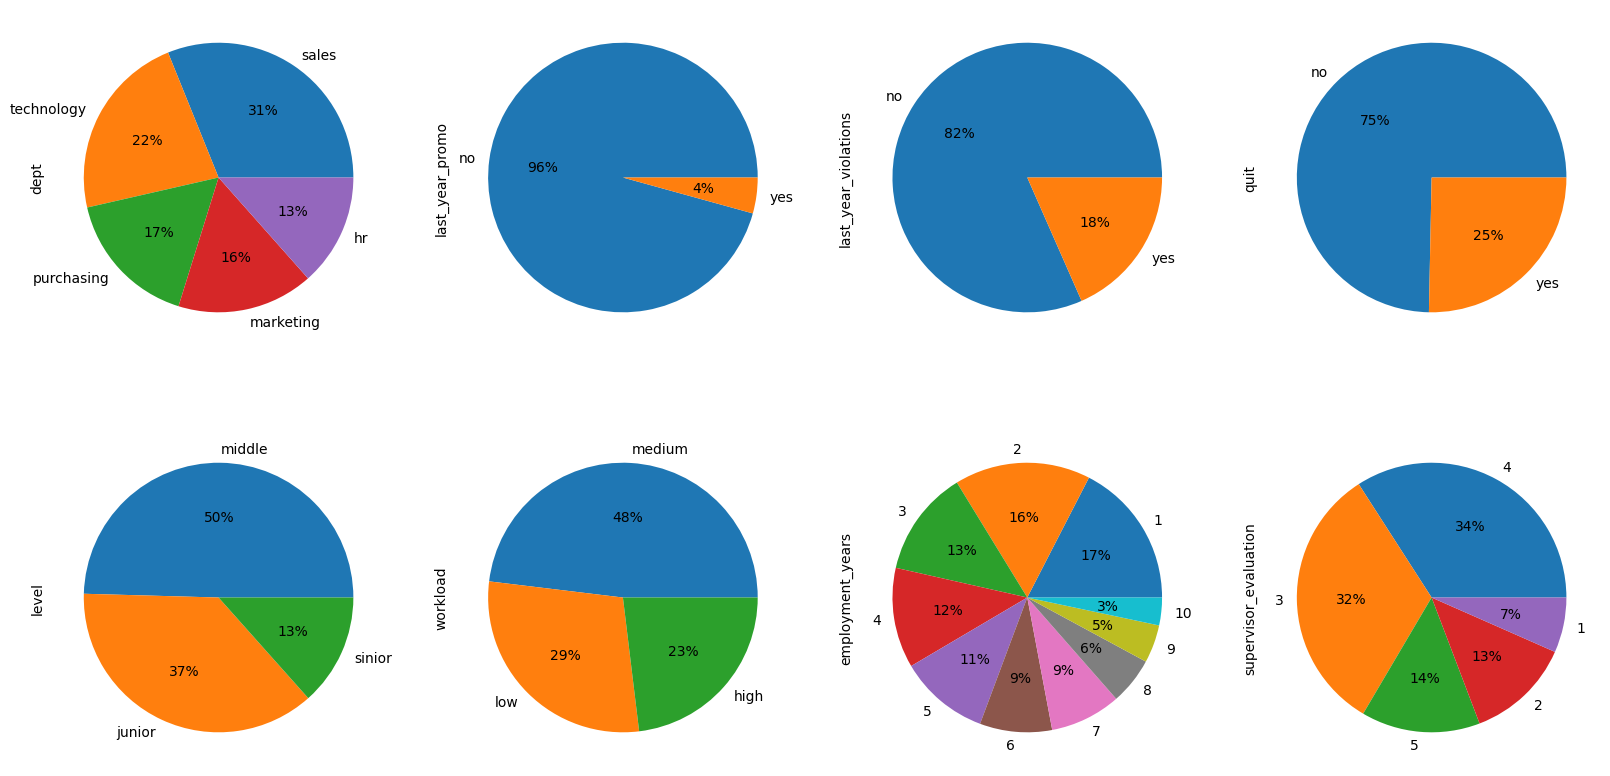

In [ ]:
plt.rcParams['figure.figsize'] = [20, 10]
j = 0
for i in ohe_columns + ord_columns:
    j += 1
    plt.subplot(2,4,j)
    df[i].value_counts().plot(kind='pie',autopct='%1.0f%%');

- наблюдается ярковыраженный дисбаланс класса в столбцах last_year_promo, last_year_violations
- в целевом признаке наблюдается дисбаланс классов, стоит это учитывать при обучении модели

**Анализ тестовой выборки:**

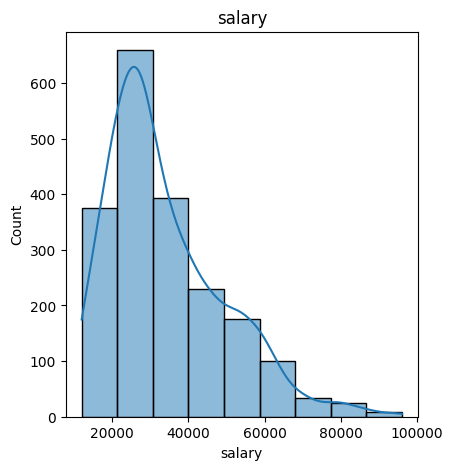

In [ ]:
plt.rcParams['figure.figsize'] = [10, 5]
j = 0
for i in num_columns:
    j += 1
    plt.subplot(1,2,j)
    sns.histplot(df_test[i], kde=True,bins=
                 round(np.log(df_test['salary'].count()))+1).set_title(i)

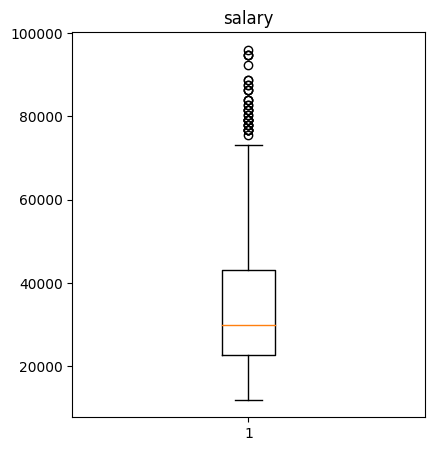

In [ ]:
j = 0
for i in num_columns:
    j += 1
    plt.subplot(1,2,j)
    plt.boxplot(df_test[i])
    plt.title(i)

In [ ]:
df_test.describe().T

,count,mean,std,min,25%,50%,75%,max
employment_years,2000.0,3.6665,2.537222,1.0,1.0,3.0,6.0,10.0
supervisor_evaluation,2000.0,3.5265,0.996892,1.0,3.0,4.0,4.0,5.0
salary,2000.0,34066.8000,15398.436729,12000.0,22800.0,30000.0,43200.0,96000.0


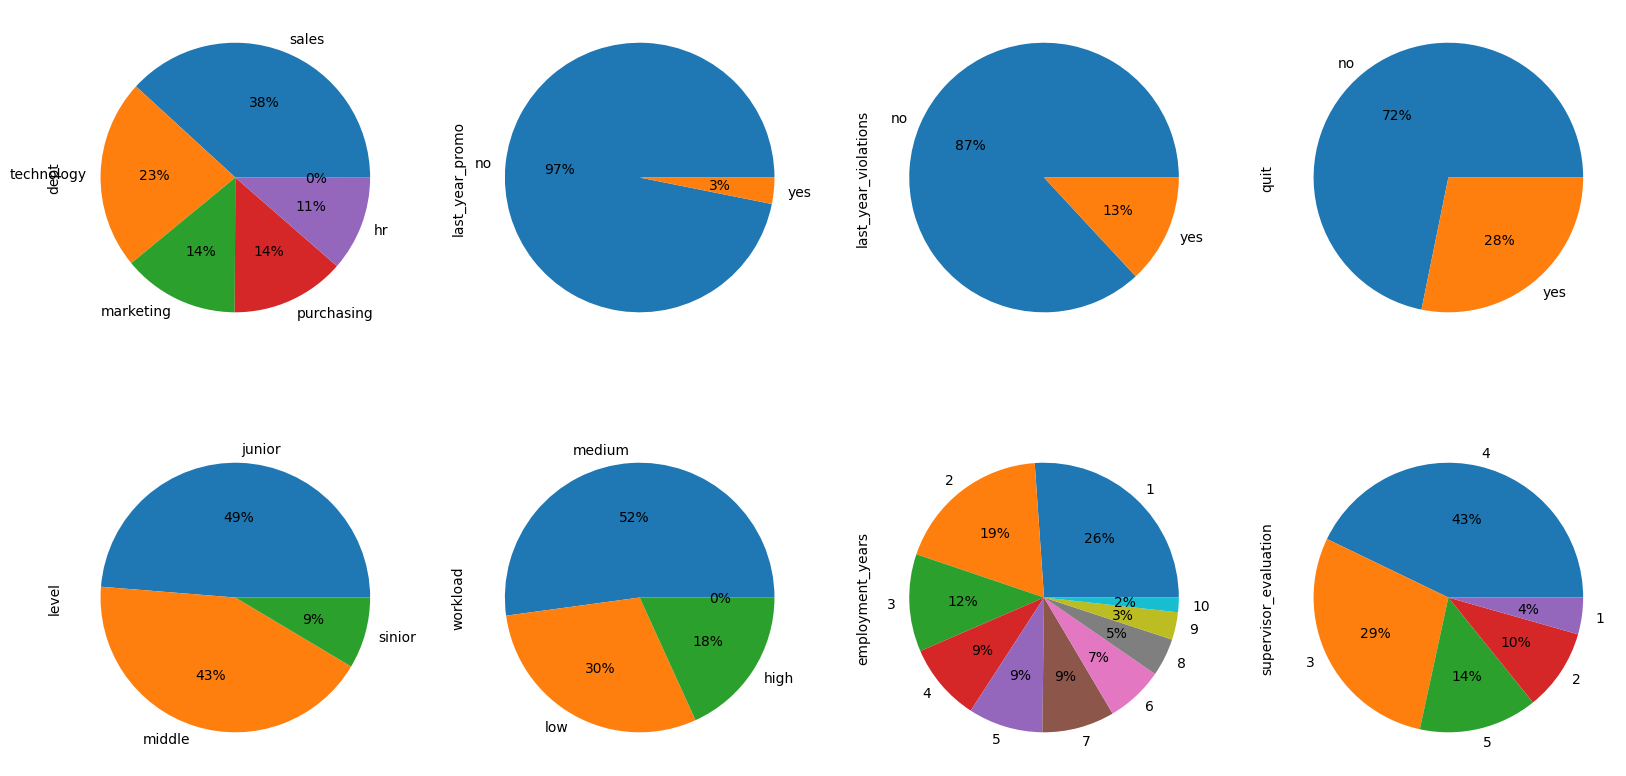

In [ ]:
plt.rcParams['figure.figsize'] = [20, 10]
j = 0
for i in ohe_columns+ord_columns:
    j += 1
    plt.subplot(2,4,j)
    df_test[i].value_counts().plot(kind='pie',autopct='%1.0f%%');

- признаки тестовой выборки имеют схожий характер с тренировочными

- в целевом признаке наблюдается дисбаланс классов, стоит это учитывать при обучении модели

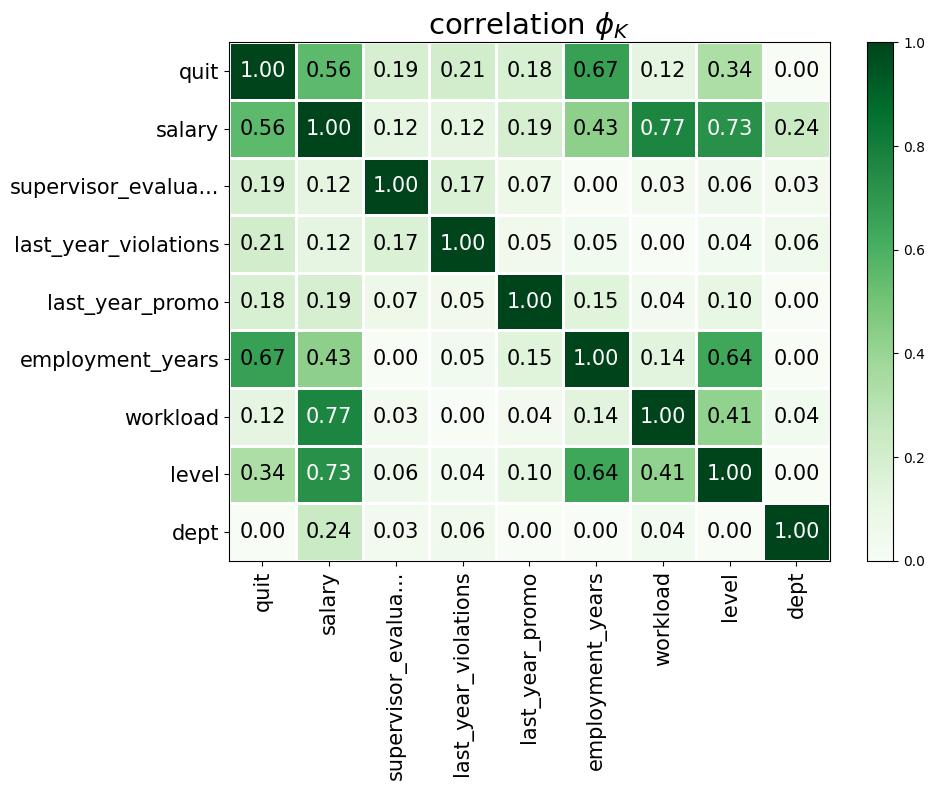

In [ ]:
phik_overview = phik_matrix(df, interval_cols=num_columns)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(10, 8)
)

- корреляционный анализ показал, что целевой признак имеет значительную связь больше сего зависит employment_years (коэф. корр.= 0,66), от slary (коэф. корр.= 0,52), от level (коэф. корр.= 0,34)

**Анализ ушедших сотрудников**

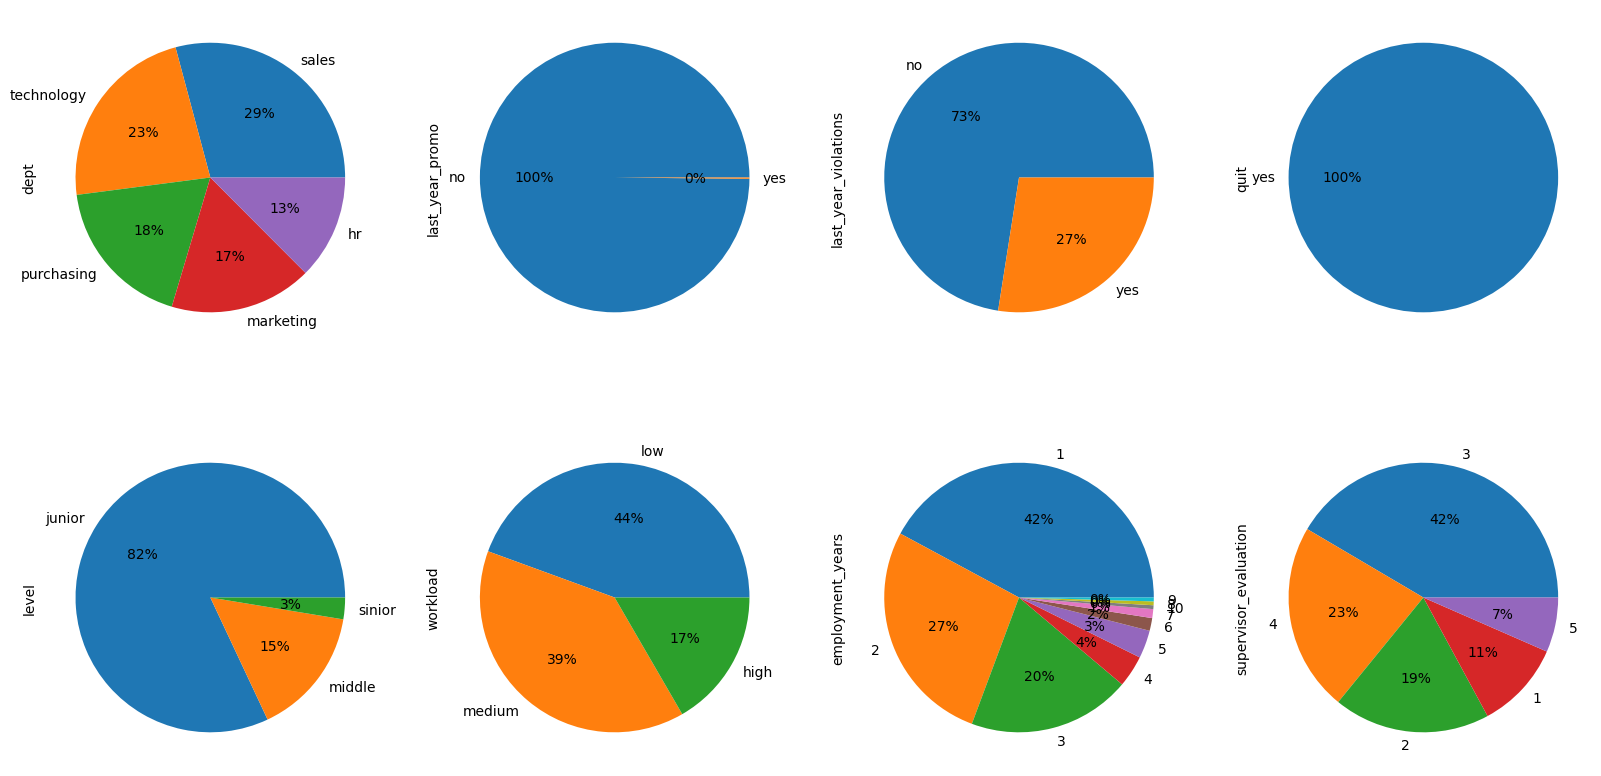

In [ ]:
plt.rcParams['figure.figsize'] = [20, 10]
j = 0
for i in ohe_columns+ord_columns:
    j += 1
    plt.subplot(2,4,j)
    df[df['quit']=='yes'][i].value_counts(normalize=True).plot(kind='pie',autopct='%1.0f%%');

- чаще всего увольняются из отдела продаж (29% от общего числа уволившихся)
- уволившеяся в 100% слачаев не имели повышения за последний год
- у уволившихся сотруднков чаще всего нет нарушений трудового договора за последний год (73% от общего числа уволившихся)
- чаще сего увольняются junior'ы (82% от общего числа уволившихся)
- чаще всего увольняются слабо- и средненагруженныесотрудники (44% и 39% соответственно от общего числа уволившихся)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2587 entries, 723290 to 692133
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   2587 non-null   object
 1   level                  2587 non-null   object
 2   workload               2587 non-null   object
 3   employment_years       2587 non-null   int64 
 4   last_year_promo        2587 non-null   object
 5   last_year_violations   2587 non-null   object
 6   supervisor_evaluation  2587 non-null   int64 
 7   salary                 2587 non-null   int64 
 8   quit                   2587 non-null   object
dtypes: int64(3), object(6)
memory usage: 202.1+ KB


In [ ]:
print('Средняя зарплата уволившегося сотрудника',df[df['quit']=='yes']['salary'].mean())
print('Средняя зарплата неуволившегося сотрудника',df[df['quit']=='no']['salary'].mean())

Средняя зарплата уволившегося сотрудника 25767.93893129771
Средняя зарплата неуволившегося сотрудника 40952.17391304348


- распределение уровня удовлетвореннсти сотрудника показывает, что у ушедших сотрудников это показатель ниже (в среднем 0,4), чем у оставшихся (в среднем 0,56)

**Вывод по разделу**
- визуальный анализ показал, что у большинства признаков наблюдается распределение Пуассона, рекомендуется при корреляционном анализе использовать метод Спирмена
- видно ряд выбросов в столбце salary, это можно объяснить тем, что высокие заработные платы в компании из-за иерархической структуры у малого процентного числа работников
- наблюдается ярковыраженный дисбаланс класса в столбцах last_year_promo, last_year_violations
- в целевом признаке наблюдается дисбаланс классов, стоит это учитывать при обучении модели
- признаки тестовой выборки имеют схожий характер с тренировочными
- в целевом признаке наблюдается дисбаланс классов, стоит это учитывать при обучении модели
- корреляционный анализ показал, что целевой признак имеет значительную связь больше сего зависит employment_years (коэф. корр.= 0,66), от slary (коэф. корр.= 0,52), от level (коэф. корр.= 0,34)

Анализ уволившегося сотрудника показал:

- чаще всего увольняются из отдела продаж (29% от общего числа уволившихся)
- уволившеяся в 100% слачаев не имели повышения за последний год
- у уволившихся сотруднков чаще всего нет нарушений трудового договора за последний год (73% от общего числа уволившихся)
- чаще сего увольняются junior'ы (82% от общего числа уволившихся)
- чаще всего увольняются слабо- и средненагруженныесотрудники (44% и 39% соответственно от общего числа уволившихся)
- средняя зарплата уволившегося сотрудника 25767.93893129771
- средняя зарплата неуволившегося сотрудника 40952.17391304348
- распределение уровня удовлетвореннсти сотрудника показывает, что у ушедших сотрудников это показатель ниже (в среднем 0,4), чем у оставшихся (в среднем 0,56)

### Добавление нового входного признака

In [ ]:
# рассчет прогноз на тренировочных данных
y_test_test_pred = oscv.predict(df.drop(['quit'], axis=1))
job_satisfaction_rate_pred = pd.DataFrame({'job_satisfaction_rate': y_test_test_pred})

df = df.reset_index()
df = pd.concat([df, job_satisfaction_rate_pred], axis=1)
df = df.set_index('id')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2587 entries, 723290 to 692133
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   2587 non-null   object 
 1   level                  2587 non-null   object 
 2   workload               2587 non-null   object 
 3   employment_years       2587 non-null   int64  
 4   last_year_promo        2587 non-null   object 
 5   last_year_violations   2587 non-null   object 
 6   supervisor_evaluation  2587 non-null   int64  
 7   salary                 2587 non-null   int64  
 8   quit                   2587 non-null   object 
 9   job_satisfaction_rate  2587 non-null   float64
dtypes: float64(1), int64(3), object(6)
memory usage: 222.3+ KB


In [ ]:
# рассчет прогноз на тестовых данных
y_test_test_pred = oscv.predict(df_test.drop(['quit'], axis=1))
job_satisfaction_rate_pred = pd.DataFrame({'job_satisfaction_rate': y_test_test_pred})

df_test = df_test.reset_index()
df_test = pd.concat([df_test, job_satisfaction_rate_pred], axis=1)
df_test = df_test.set_index('id')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 485046 to 771859
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   1998 non-null   object 
 1   level                  1999 non-null   object 
 2   workload               2000 non-null   object 
 3   employment_years       2000 non-null   int64  
 4   last_year_promo        2000 non-null   object 
 5   last_year_violations   2000 non-null   object 
 6   supervisor_evaluation  2000 non-null   int64  
 7   salary                 2000 non-null   int64  
 8   quit                   2000 non-null   object 
 9   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(3), object(6)
memory usage: 171.9+ KB


- добавлен новой признак job_satisfaction_rate в тренировочную и тестовую выборку, предсказанный моделью полученной в первой задаче

**Вывод по разделу**
- добавлен новой признак job_satisfaction_rate в тренировочную и тестовую выборку, предсказанный моделью полученной в первой задаче

### Подготовка данных

In [ ]:
X_train=df.drop(['quit'], axis=1)
y_train=df['quit']
X_test=df_test.drop(['quit'], axis=1)
y_test=df_test['quit']
ohe_columns = ['dept','last_year_promo','last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['salary','job_satisfaction_rate', 'employment_years','supervisor_evaluation']

In [ ]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('simpleImputer_ohe2', SimpleImputer(missing_values='', strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
    ]
    )

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('simpleImputer_before_ord2', SimpleImputer(missing_values='', strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high'],
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ],
    remainder='passthrough'
)
le=LabelEncoder()
y_train=le.fit_transform(y_train)
y_test=le.transform(y_test)

**Вывод по разделу**
- подготовка признаков выполнена в пайплайне
- для признаков проведено масштабирование и кодирование
- при кодировании использовался OneHotEncoder для критериальных признаков и OrdinalEncoder для ранжированных признаков

### Обучение моделей

- для разработки модели предсказание уровня удовлетворённости сотрудника использовались модели DecisionTreeClassifier, KNeighborsClassifier, LogisticRegression и SVC, для автоматизации подбора гиперпараметров используем RandomizedSearchCV

In [ ]:
pipe_final = imbpipeline([
    ('preprocessor', data_preprocessor),
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE)),

])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 8),
        'models__min_samples_leaf': range(1,8),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
     {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=200)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 8),
        'models__min_samples_leaf': range(1,8),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },

    # словарь для модели KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
        # указываем гиперпараметр модели n_neighbors
        'models__n_neighbors': range(2, 8),
        # указываем список методов масштабирования
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(),'passthrough']
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            class_weight='balanced',
            random_state=RANDOM_STATE,
            solver='liblinear'
        )],
        'models__penalty': ['l1','l2'],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },

    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE,kernel = 'poly')],
        'models__degree': range(1, 4),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),RobustScaler(), 'passthrough']

    }
]

randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)


randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('simpleImputer_ohe2',
                                                                   SimpleImputer(missing_values='',
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                

При первой итерации получены следующая модель с ее гиперпараметрами:

- RandomForestClassifier(max_depth=4, max_features=3, n_estimators=200, random_state=42)

- анализ результатов Randomized_search_CV показал, что лучше всего с задачей справляются модель DecisionTreeClassifier
- для более детального подбора гиперпараметров использовался OptunaSearchCV

In [ ]:
pipe_final = imbpipeline([
    ('preprocessor', data_preprocessor),
    ('smote', SMOTE(random_state=RANDOM_STATE, k_neighbors=5)),
    ('models', RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=200))
])

parameters = {
    'models__criterion': distributions.CategoricalDistribution(['gini', 'entropy', 'log_loss']),
    'models__max_depth': distributions.CategoricalDistribution([None] + [i for i in range(2, 7)]),
    'models__min_samples_leaf': distributions.IntDistribution(1,200),
    'models__max_features': distributions.IntDistribution(1,200),
    'smote__k_neighbors' : distributions.IntDistribution(3,12),
    'preprocessor__num': distributions.CategoricalDistribution([StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'])
}

oscv4 = OptunaSearchCV(
    pipe_final,
    parameters,
    scoring='roc_auc',
    n_jobs=-1,
    cv=5,
    n_trials=200,
    random_state=RANDOM_STATE
)

oscv4.fit(X_train, y_train)


print('Лучшая модель и её параметры:\n\n', oscv4.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', oscv4.best_score_)



# рассчет прогноз на тестовых данных
y_test_pred = oscv4.predict_proba(X_test)

print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred[:,1])}')

[I 2024-03-24 12:35:06,385] A new study created in memory with name: no-name-67fa6fa9-0132-41e3-8941-c6e16d980117
[I 2024-03-24 12:35:17,309] Trial 1 finished with value: 0.904417410928956 and parameters: {'models__criterion': 'gini', 'models__max_depth': 6, 'models__min_samples_leaf': 199, 'models__max_features': 154, 'smote__k_neighbors': 11, 'preprocessor__num': MinMaxScaler()}. Best is trial 1 with value: 0.904417410928956.
[I 2024-03-24 12:35:24,211] Trial 0 finished with value: 0.9063835572533392 and parameters: {'models__criterion': 'log_loss', 'models__max_depth': None, 'models__min_samples_leaf': 13, 'models__max_features': 90, 'smote__k_neighbors': 8, 'preprocessor__num': StandardScaler()}. Best is trial 0 with value: 0.9063835572533392.
[I 2024-03-24 12:35:25,532] Trial 2 finished with value: 0.9090504788124016 and parameters: {'models__criterion': 'gini', 'models__max_depth': None, 'models__min_samples_leaf': 166, 'models__max_features': 115, 'smote__k_neighbors': 11, 'prep

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('simpleImputer_ohe2',
                                                                   SimpleImputer(missing_values='',
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                

Гиперпараметры модели с наилучшей метрикой выглядят так :

- RandomForestClassifier(max_depth=4, max_features=8,min_samples_leaf=12, n_estimators=200, random_state=42)
- MinMaxScaler()
- SMOTE(k_neighbors=12, random_state=42)
- OneHotEncoder(drop='first',handle_unknown='ignore', sparse=False)
- OrdinalEncoder(categories=[['junior', 'middle', 'sinior'],['low', 'medium', 'high']],handle_unknown='use_encoded_value',unknown_value=np.nan))
- SimpleImputer(strategy='most_frequent')

- метрика ROC-AUC на тестовой выборке оказалась 0.9199, следовательно точность прогнозирования модели можно считать достаточной

**Вывод по разделу**
- для разработки модели предсказание уровня удовлетворённости сотрудника использовались модели DecisionTreeClassifier, KNeighborsClassifier, LogisticRegression и SVC, для автоматизации подбора гиперпараметров используем RandomizedSearchCV

При первой итерации получены следующая модель с ее гиперпараметрами:

- DecisionTreeClassifier(max_depth=4, max_features=7, random_state=42)

- анализ результатов Randomized_search_CV показал, что лучше всего с задачей справляется модель DecisionTreeClassifier
- для более детального подбора гиперпараметров использовался OptunaSearchCV

При второй итерации получены следующая модель с ее гиперпараметрами:

- DecisionTreeClassifier(max_depth=7, max_features=92, min_samples_leaf=34, criterion='entropy', random_state=42)

- для улучшения модели будем использовался оверсемплирование для решения проблемы с дисбалансом класса
- для улучшения модели проведен анализ признаков
- выявлено, что наибольшая точность модели наблюдается при использовании 6 признаков

Гиперпараметры модели с наилучшей метрикой выглядят так :

- RandomForestClassifier(max_depth=4, max_features=8,min_samples_leaf=12, n_estimators=200, random_state=42)
- MinMaxScaler()
- SMOTE(k_neighbors=12, random_state=42)
- OneHotEncoder(drop='first',handle_unknown='ignore', sparse=False)
- OrdinalEncoder(categories=[['junior', 'middle', 'sinior'],['low', 'medium', 'high']],handle_unknown='use_encoded_value',unknown_value=np.nan))
- SimpleImputer(strategy='most_frequent')

- метрика ROC-AUC на тестовой выборке оказалась 0.921, следовательно точность прогнозирования модели можно считать достаточной


### Вывод по задаче 2

В данной задаче разработана модель, которая предсказывает увольнение сотрудника из компании

Данные были получены из следующих файлов /datasets/train_quit.csv, /datasets/test_features.csv, /datasets/test_target_quit.csv. Перед началом исследовательской части был произведен обзор и проверка на адекватность полученных данных. Выявлено, что:

- все данные трех датасетов соответствуют описанию данных

Перед началом исследования была проведена предобработка данных,в рамках которой выялено:

- явных дубликатов в данных не обнаружено
- найдены неявные дубликаты в признаках сотрудников (абсолютно идентичные по признакам сотрудники), будем считать такие записи багрепортом, решено удалить их из рассмотрения

В ходе исследования данных выявлены следующие особенности:

- визуальный анализ показал, что у большинства признаков наблюдается распределение Пуассона, рекомендуется при корреляционном анализе использовать метод Спирмена
- видно ряд выбросов в столбце salary, это можно объяснить тем, что высокие заработные платы в компании из-за иерархической структуры у малого процентного числа работников
- наблюдается ярковыраженный дисбаланс класса в столбцах last_year_promo, last_year_violations
- в целевом признаке наблюдается дисбаланс классов, стоит это учитывать при обучении модели
- признаки тестовой выборки имеют схожий характер с тренировочными
- в целевом признаке наблюдается дисбаланс классов, стоит это учитывать при обучении модели
- корреляционный анализ показал, что целевой признак имеет значительную связь больше сего зависит employment_years (коэф. корр.= 0,66), от slary (коэф. корр.= 0,52), от level (коэф. корр.= 0,34)

Анализ уволившегося сотрудника показал:

- чаще всего увольняются из отдела продаж (29% от общего числа уволившихся)
- уволившеяся в 100% слачаев не имели повышения за последний год
- у уволившихся сотруднков чаще всего нет нарушений трудового договора за последний год (73% от общего числа уволившихся)
- чаще сего увольняются junior'ы (82% от общего числа уволившихся)
- чаще всего увольняются слабо- и средненагруженныесотрудники (44% и 39% соответственно от общего числа уволившихся)
- средняя зарплата уволившегося сотрудника 25767.93893129771
- средняя зарплата неуволившегося сотрудника 40952.17391304348
- распределение уровня удовлетвореннсти сотрудника показывает, что у ушедших сотрудников это показатель ниже (в среднем 0,4), чем у оставшихся (в среднем 0,56)

Перед началом обучения проведена подоготвка дынных:

- добавлен новой признак job_satisfaction_rate в тренировочную и тестовую выборку, предсказанный моделью полученной в первой задаче
- подготовка признаков выполнена в пайплайне
- для признаков проведено масштабирование и кодирование
- при кодировании использовался OneHotEncoder для критериальных признаков и OrdinalEncoder для ранжированных признаков

На этапе обучения модели были выполнены следующие процедуры:

- для разработки модели предсказание уровня удовлетворённости сотрудника использовались модели DecisionTreeClassifier, KNeighborsClassifier, RandomForestClassifier, LogisticRegression и SVC, для автоматизации подбора гиперпараметров используем RandomizedSearchCV

При первой итерации получены следующая модель с ее гиперпараметрами:

- RandomForestClassifier(max_depth=4, max_features=3, n_estimators=200, random_state=42)

- анализ результатов Randomized_search_CV показал, что лучше всего с задачей справляется модель RandomForestClassifier
- для более детального подбора гиперпараметров использовался OptunaSearchCV

Гиперпараметры модели с наилучшей метрикой выглядят так :

- RandomForestClassifier(max_depth=4, max_features=8,min_samples_leaf=12, n_estimators=200, random_state=42)
- MinMaxScaler()
- SMOTE(k_neighbors=12, random_state=42)
- OneHotEncoder(drop='first',handle_unknown='ignore', sparse=False)
- OrdinalEncoder(categories=[['junior', 'middle', 'sinior'],['low', 'medium', 'high']],handle_unknown='use_encoded_value',unknown_value=np.nan))
- SimpleImputer(strategy='most_frequent')

- метрика ROC-AUC на тестовой выборке оказалась 0.921, следовательно точность прогнозирования модели можно считать достаточной

## Общий вывод

В ходе работы разработаны 2 модель, которые предсказывают уровень удовлетворённости сотрудника и увольнение сотрудника из компании

Данные были получены из следующих файлов /datasets/train_job_satisfaction_rate.csv, /datasets/test_features.csv, /datasets/test_target_job_satisfaction_rate.csv, /datasets/train_quit.csv, /datasets/test_features.csv, /datasets/test_target_quit.csv. Перед началом исследовательской части был произведен обзор и проверка на адекватность полученных данных. Выявлено, что:

- в train_job_satisfaction и test_features присутствуют немногочисленные пропуски в данных в стобцах dept, level
- все данные пяти датасетов соответствуют описанию данных

Перед началом исследования была проведена предобработка данных,в рамках которой выялено:

- так как пропуски не многочисленные в таблицах, а данных для анализа мало, пропуски были заменены на самые популярные категории
- дубликатов в полученных данных не обнаружено

В ходе исследования данных выявлены следующие особенности:

- визуальный анализ показал, что у большинства признаков наблюдается распределение Пуассона, рекомендуется при корреляционном анализе использовать метод Спирмена
- видно ряд выбросов в столбце salary, это можно объяснить тем, что высокие заработные платы в компании из-за иерархической структуры у малого процентного числа работников
- наблюдается ярковыраженный дисбаланс класса в столбцах last_year_promo, last_year_violations
- признаки тестовой выборки имеют схожий характер с тренировочными
- корреляционный анализ показал, что целевой признак имеет высокую зависимость от supervisir_evalution
- в целевом признаке наблюдается дисбаланс классов, стоит это учитывать при обучении модели
- признаки тестовой выборки имеют схожий характер с тренировочными
- в целевом признаке наблюдается дисбаланс классов, стоит это учитывать при обучении модели
- корреляционный анализ показал, что целевой признак имеет значительную связь больше сего зависит employment_years (коэф. корр.= 0,66), от slary (коэф. корр.= 0,52), от level (коэф. корр.= 0,34)

Анализ уволившегося сотрудника показал:

- чаще всего увольняются из отдела продаж (29% от общего числа уволившихся)
- уволившеяся в 100% слачаев не имели повышения за последний год
- у уволившихся сотруднков чаще всего нет нарушений трудового договора за последний год (73% от общего числа уволившихся)
- чаще сего увольняются junior'ы (82% от общего числа уволившихся)
- чаще всего увольняются слабо- и средненагруженныесотрудники (44% и 39% соответственно от общего числа уволившихся)
- средняя зарплата уволившегося сотрудника 25767.93893129771
- средняя зарплата неуволившегося сотрудника 40952.17391304348
- распределение уровня удовлетвореннсти сотрудника показывает, что у ушедших сотрудников это показатель ниже (в среднем 0,4), чем у оставшихся (в среднем 0,56)

Перед началом обучения проведена подоготвка данных:

- подготовка признаков выполнена в пайплайне
- для признаков проведено масштабирование и кодирование
- при кодировании использовался OneHotEncoder для критериальных признаков и OrdinalEncoder для ранжированных признаков

На этапе обучения модели были выполнены следующие процедуры:

- создана своя метрика SMAPE, критерий успехадя которой SMAPE ≤15 на тестовой выборке
- для разработки модели предсказание уровня удовлетворённости сотрудника использовались модели DecisionTreeClassifier, LinearRegression, LinearSVR, DecisionTreeClassifier, KNeighborsClassifier, LogisticRegression и SVC для автоматизации подбора гиперпараметров используем OptunaSearchCV

Гиперпараметры модели с наилучшей метрикой для первой модели выглядят так:

- DecisionTreeRegressor(max_depth=380, max_features=285, max_leaf_nodes=224, random_state=42)
- StandardScaler()
- OneHotEncoder(drop='first',handle_unknown='ignore', sparse=False)
- OrdinalEncoder(categories=[['junior', 'middle', 'sinior'],['low', 'medium', 'high']],handle_unknown='use_encoded_value',unknown_value=np.nan))
- SimpleImputer(strategy='most_frequent')


Гиперпараметры модели с наилучшей метрикой для второй модели выглядят так:

- RandomForestClassifier(max_depth=4, max_features=8,min_samples_leaf=12, n_estimators=200, random_state=42)
- MinMaxScaler()
- SMOTE(k_neighbors=12, random_state=42)
- OneHotEncoder(drop='first',handle_unknown='ignore', sparse=False)
- OrdinalEncoder(categories=[['junior', 'middle', 'sinior'],['low', 'medium', 'high']],handle_unknown='use_encoded_value',unknown_value=np.nan))
- SimpleImputer(strategy='most_frequent')

Анализ метрик показал:
- метрика SMAPE на тестовой выборке первой модели оказалась <15, следовательно точность прогнозирования модели можно считать достаточной
- метрика ROC-AUC на тестовой выборке второй модели оказалась 0.921, следовательно точность прогнозирования модели можно считать достаточной

- Рекомендуется проводить анализ по полученным моделям для сотрудников не реже 1 раза в квартал, при получении сигнала прогнозирующего уход сотрудника, провести мероприятия по устраненинию такого желания (повышения или увеличения зароботной вилки)